# Corona in Hamburg

In [24]:
import datetime
import os
import re
import urllib.parse

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [25]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
BOROUGHS = {
    "Altona": 275265,
    "Bergedorf": 130260,
    "Eimsbüttel": 267053,
    "Hamburg Mitte": 301546,
    "Hamburg Nord": 314595,
    "Harburg": 169426,
    "Wandsbek": 441015,
    "Hamburg": 1899160,
}

In [26]:
RESTRICTIONS = {
    datetime.date(2020, 3, 16): "schools closed",
    datetime.date(2020, 3, 23): "lockdown",
    datetime.date(2020, 4, 20): "lockdown end",
    datetime.date(2020, 4, 27): "masks required",
    datetime.date(2020, 10, 12): "masks required in more areas",
    datetime.date(2020, 10, 26): "contact restrictions",
    datetime.date(2020, 11, 2): "lockdown \"light\"",
}

In [27]:
def parse_data(src):
    soup = bs4.BeautifulSoup(src)
    historic_case_data_header = soup.find("h2", text="Inzidenz zum Download")
    if historic_case_data_header:
        df = pd.read_excel(
            urllib.parse.urljoin(
                CORONA_DATA_URL,
                historic_case_data_header.parent.find_next("div").a["href"]
            ),
            index_col=1,
            skiprows=[0],
            parse_dates=True
        )
        
        df = df.drop(
            set(df.columns) - {"Datum", "Gesamthaft gemeldete SARS-CoV-2 Infektionen"},
            axis="columns"
        ).rename(columns={
            "Datum": "date",
            "Gesamthaft gemeldete SARS-CoV-2 Infektionen": "cases"
        }).dropna().diff().dropna().astype(int)

        daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
        daily_cases.update(df)
        daily_cases.astype(int).to_csv("corona-hamburg-daily.csv")

    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if not header:
        header = soup.find("h2", text="Neue Fälle: Sieben Tage Inzidenz")

    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Bei der Inzidenz"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            with open("corona-hamburg-daily.csv", "r") as f:
                lines = [line.strip() for line in f]

            with open("corona-hamburg-daily.csv", "a") as f:
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find("h3", text="Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken")
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp,"total"]
        active_cases = [timestamp,"active"]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip())
            cases = (
                row.find(attrs={"data-label": "Fälle vergangene 14 Tage"})
                or row.find(attrs={"data-label": "Fälle letzte 14 Tage"})
            )
            if cases:
                active_cases.append(cases.text.strip())

        with open("corona-hamburg.csv") as f:
            lines = [line.strip() for line in f]
        
        with open("corona-hamburg.csv", "a") as f:
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2:
                f.write(f"{total_cases_line}\n")

            active_cases_line = ",".join(active_cases)
            if active_cases_line not in lines and len(active_cases) > 2:
                f.write(f"{active_cases_line}\n")

In [28]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    parse_data(r.text)

In [29]:
daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()

In [30]:
df = pd.read_csv("corona-hamburg.csv", index_col=0, parse_dates=True)
total_cases = df[df["type"] == "total"].drop(["type"], axis="columns").astype(int)
new_cases = total_cases.diff().dropna().astype(int)

In [31]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [32]:
def stackplot(df, title):
    plt.stackplot(df.index, *df.values.T, labels=df.columns)
    plt.legend(loc="upper left")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.xticks(rotation=60)
    plt.xlim(xmin=df.index[0])
    plt.grid()

## Total Cases

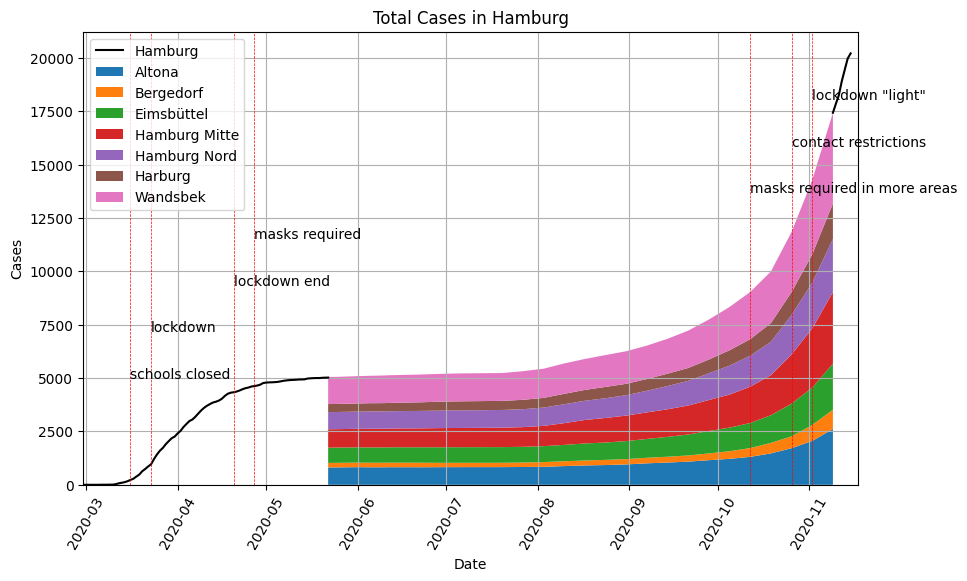

In [33]:
stackplot(total_cases, "Total Cases in Hamburg")
first_total = daily_cases.index.get_loc(total_cases.index[0]) + 1
last_total = total_cases.index.intersection(daily_cases.index)[-1]
total_daily_cases = pd.DataFrame([total_cases.T[last_total].sum()], index=[last_total], columns=["cases"]).append(daily_cases[last_total:].drop(index=[last_total])).cumsum()
plt.plot(total_daily_cases.index, total_daily_cases.values, "black", label="Hamburg")
plt.plot(daily_cases.index[:first_total], daily_cases.cumsum()[:first_total], "black")
y = 5000
dy = (total_daily_cases.values.max() - 5000) / len(RESTRICTIONS)
for date in RESTRICTIONS:
    plt.axvline(x=date, color="red", linestyle="dashed", linewidth=0.5)
    plt.annotate(RESTRICTIONS[date], (date, y), )
    y += dy
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0])
plt.show()

In [34]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-09-07,1008,259,884,1244,1014,550,1567,6526
2020-09-14,1045,272,931,1293,1090,578,1636,6845
2020-09-21,1086,290,984,1357,1158,602,1752,7229
2020-09-28,1155,318,1049,1454,1250,648,1875,7749
2020-10-05,1218,357,1107,1548,1359,718,2031,8338
2020-10-12,1311,412,1174,1704,1449,778,2212,9040
2020-10-19,1474,491,1298,1876,1568,874,2420,10001
2020-10-26,1717,555,1532,2308,1849,1071,2820,11852
2020-11-02,2057,748,1751,2775,2142,1329,3484,14286


In [35]:
total_daily_cases.T

,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15
cases,17437,17859,18255,18915,19450,19978,20221


## New Cases

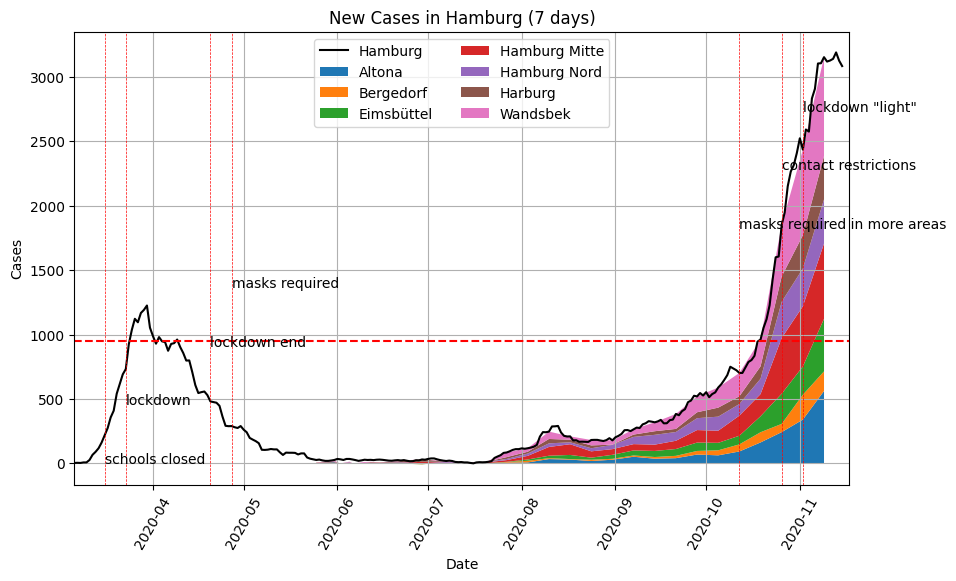

In [36]:
stackplot(new_cases, "New Cases in Hamburg (7 days)")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
plt.axhline(y=950, c="r", ls="dashed")
y = 0
dy = daily_cases_rolling7.values.max() / len(RESTRICTIONS)
for date in RESTRICTIONS:
    plt.axvline(x=date, c="r", ls="--", lw=0.5)
    plt.annotate(RESTRICTIONS[date], (date, y), )
    y += dy
plt.legend(loc="upper center", ncol=2)
plt.xlim(xmin=daily_cases_rolling7.index[0])
plt.show()

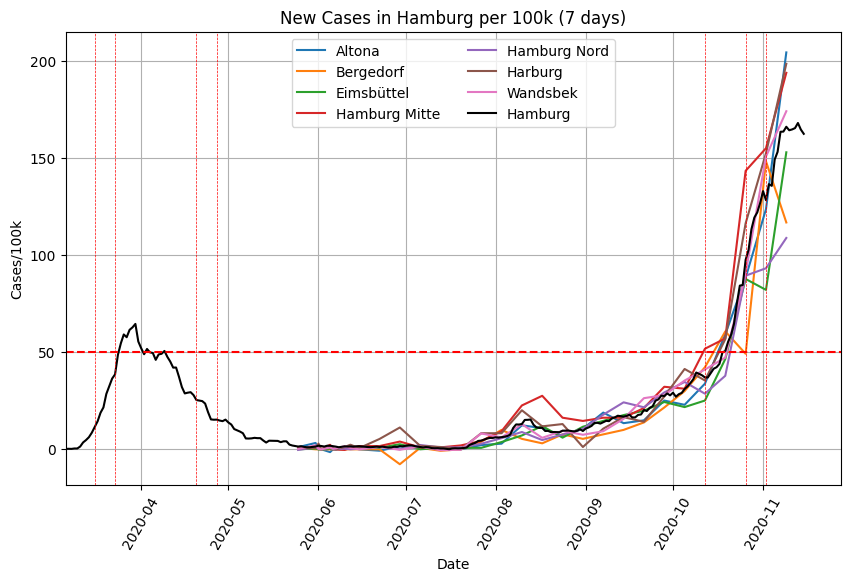

In [37]:
for borough in new_cases.columns:
    plt.plot(new_cases.index, new_cases[borough] / BOROUGHS[borough] * 1e5, label=borough)

plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values / BOROUGHS["Hamburg"] * 1e5, "k-", label="Hamburg")
plt.axhline(y=50, c="r", ls="--")
for date in RESTRICTIONS:
    plt.axvline(x=date, c="r", ls="--", lw=0.5)
plt.title("New Cases in Hamburg per 100k (7 days)")
plt.legend(loc="upper center", ncol=2)
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases_rolling7.index[0])
plt.grid()
plt.show()

In [38]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-09-07,52,10,39,49,56,18,41,265
2020-09-14,37,13,47,49,76,28,69,319
2020-09-21,41,18,53,64,68,24,116,384
2020-09-28,69,28,65,97,92,46,123,520
2020-10-05,63,39,58,94,109,70,156,589
2020-10-12,93,55,67,156,90,60,181,702
2020-10-19,163,79,124,172,119,96,208,961
2020-10-26,243,64,234,432,281,197,400,1851
2020-11-02,340,193,219,467,293,258,664,2434


In [39]:
(new_cases / pd.DataFrame(BOROUGHS, index=new_cases.index) * 1e5).round(2).tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-09-07,18.89,7.68,14.60,16.25,17.80,10.62,9.30,13.95
2020-09-14,13.44,9.98,17.60,16.25,24.16,16.53,15.65,16.80
2020-09-21,14.89,13.82,19.85,21.22,21.62,14.17,26.30,20.22
2020-09-28,25.07,21.50,24.34,32.17,29.24,27.15,27.89,27.38
2020-10-05,22.89,29.94,21.72,31.17,34.65,41.32,35.37,31.01
2020-10-12,33.79,42.22,25.09,51.73,28.61,35.41,41.04,36.96
2020-10-19,59.22,60.65,46.43,57.04,37.83,56.66,47.16,50.60
2020-10-26,88.28,49.13,87.62,143.26,89.32,116.27,90.70,97.46
2020-11-02,123.52,148.17,82.01,154.87,93.14,152.28,150.56,128.16


In [40]:
daily_cases_rolling7.tail(8).T

date,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15
cases,3104.0,3151.0,3117.0,3125.0,3138.0,3188.0,3124.0,3082.0


In [41]:
(daily_cases_rolling7 / BOROUGHS["Hamburg"] * 1e5).tail(8).round(2).T

date,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15
cases,163.44,165.92,164.13,164.55,165.23,167.86,164.49,162.28


## Daily Cases

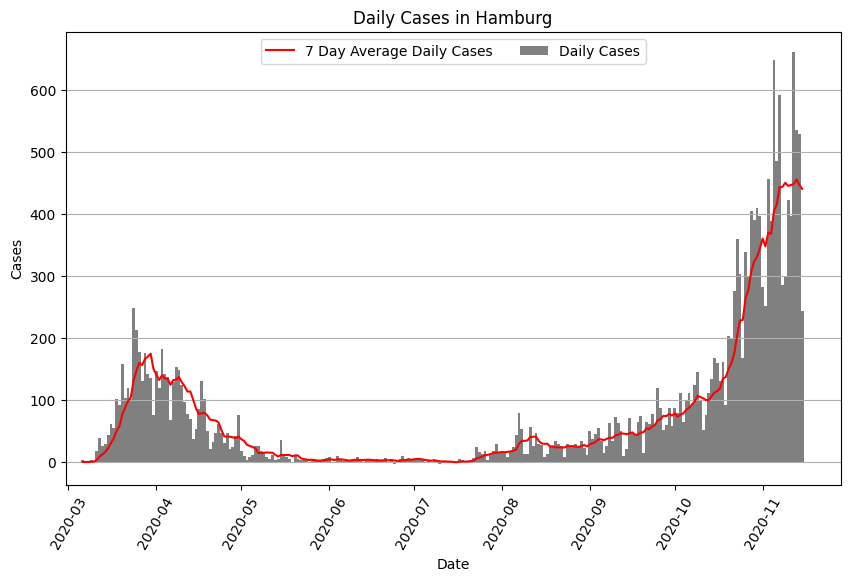

In [42]:
plt.bar(daily_cases.index, daily_cases.values.T[0], width=1, color="grey", label="Daily Cases")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7 / 7, "red", label="7 Day Average Daily Cases")
plt.title("Daily Cases in Hamburg")
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases.index[0])
plt.grid(axis="y")
plt.show()

In [43]:
daily_cases.tail(8).T

date,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15
cases,285,298,422,396,660,535,528,243


In [44]:
daily_cases.diff().tail(8).T

date,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15
cases,-307.0,13.0,124.0,-26.0,264.0,-125.0,-7.0,-285.0


In [45]:
(daily_cases_rolling7 / 7).tail(8).T.round(2)

date,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15
cases,443.43,450.14,445.29,446.43,448.29,455.43,446.29,440.29


In [46]:
(daily_cases_rolling7 / 7).diff().tail(8).T.round(2)

date,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15
cases,0.29,6.71,-4.86,1.14,1.86,7.14,-9.14,-6.0
